In [2]:
%matplotlib ipympl
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os
import openpyxl 
from scipy.integrate import simps
import adi
import pandas as pd
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from scipy.ndimage import gaussian_filter1d

In [3]:
font_path = 'C:\\Windows\\Fonts\\simsun.ttc'  # 宋體
font_prop = FontProperties(fname=font_path)

npy = 'no' #! 是否儲存npy檔
graph = ['', '', '']   # 是否要畫圖['PPG', 'D1', 'D2']
data = 'Patient'    #要用病患還是正常人資料

if data == 'Patient':
    data_file = 'F:\\Python\\PPG\\All data\\Patient_Signal'
    graph_file = 'F:\\Python\\PPG\\All data\\Patient_Signal\\graph'
elif data == 'Normal':
    data_file = 'F:\\Python\\PPG\\All data\\Normal_Signal'
    graph_file = 'F:\\Python\\PPG\\All data\\Normal_Signal\\graph'

bad_graph = 'F:\\Python\\PPG\\All data\\Bad_Graph'

In [4]:
def butter(DataL, DataR, cut_low, cut_high, sample_rate, order):
    nyqs = sample_rate * 0.5
    H_cut = cut_high / nyqs
    L_cut = cut_low / nyqs
    sos = signal.butter(order, [L_cut, H_cut], analog=False, btype='bandpass', output='sos')
    Filter_Left = signal.sosfiltfilt(sos, DataL)
    Filter_Right = signal.sosfiltfilt(sos, DataR)
    return Filter_Left, Filter_Right

def derivative(Data, Level, values=[]):
    result = np.gradient(Data)

    if Level == 0:
        values.append(Data)
        return 0
    else:
        values.append(Data)
        return derivative(result, Level - 1, values)
    
def process_wave(cycle):
    values = []
    derivative(cycle, 3, values)
    values = np.array(values)
    origin, derivative_1, derivative_2, derivative_3 = values

    return [derivative_1, derivative_2, derivative_3]

In [5]:
def Find_Path(path):

    File_path = []

    #find all Data_file path 
    for root,  subfolders,  filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('.txt'):
                continue
            filepath = root +'/'+ filename
            new_filepath = filepath.replace("\\", "/")
            File_path.append(new_filepath)

    return File_path

In [6]:
def get_Imformation(path):
    test=path.split('/')
    Name = test[-3]
    State_check = test[-4]
    if State_check =='易堵':
        State = '0'
    else: 
        State = '1'

    file_name = test[len(test)-1]
    name_check = file_name.find('R')
    if name_check != -1:
        hands = 'Right'
    else:
        hands = 'Left'
    
    imformation =[Name, hands, State]

    return imformation, Name

In [7]:
def plot_1x3(p1, p2, p3, Name, i):
    plt.figure(figsize=(13, 4))
    plt.plot(p1)
    plt.plot(p2)
    plt.plot(p3)
    plt.title(f'{Name} PPG signal {i}', fontproperties=font_prop)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()


def plot_1x2(p1, p2, Name, i):
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(p1)
    plt.title(f'{Name} PPG signal {i}', fontproperties=font_prop)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(p2)
    plt.title('Cutting cycle')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()

    plt.tight_layout()
    plt.show()

def plot_2x1(p1, p2, Name, i):
    plt.figure(figsize=(5, 6))
    plt.subplot(2, 1, 1)
    plt.plot(p1)
    plt.title(f'{Name} PPG signal {i}', fontproperties=font_prop)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(p2)
    plt.title('Cutting cycle')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()

    plt.tight_layout()
    plt.show()


def plot_3x1(p1, p2, p3, Name, i):
    plt.figure(figsize=(5, 8))
    plt.subplot(3, 1, 1)
    plt.plot(p1)
    #plt.tick_params(labelbottom=False, labelleft=False)
    plt.title(f'{Name} PPG signal {i}', fontproperties=font_prop)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.subplot(3, 1, 2)
    plt.plot(p2)
    #plt.tick_params(labelbottom=False, labelleft=False)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.subplot(3, 1, 3)
    plt.plot(p3)
    #plt.tick_params(labelbottom=False, labelleft=False)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()

    plt.tight_layout()
    plt.show()

    
def resize_wave(cycle, Name, i, target_length=2000): # type: ignore
    derivative = process_wave(cycle)

    resized = signal.resample(cycle, target_length)

    for j in range(3):
        derivative[j] = signal.resample(derivative[j], target_length)

    plot_3x1(resized, derivative[0], derivative[1], Name, i)
    plot_2x1(resized, derivative[0], Name, i)
    plot_2x1(resized, derivative[1], Name, i)
    


In [8]:
def analyze():
    channel1_id = 2
    channel2_id = 4
    record_id = 1

    File_path = Find_Path("F:\\正常人Data") #!正常人

    print('找到資料筆數', len(File_path))

    df_c = pd.DataFrame()
    for j, path in tqdm(enumerate(File_path), total=len(File_path), desc='Processing'):
        Data = adi.read_file(path)
        imformation,Name = get_Imformation(path)

        Right = Data.channels[channel1_id - 1].get_data(record_id)
        Left = Data.channels[channel2_id - 1].get_data(record_id)

        Filter_Left,Filter_Right = butter(Left, Right, 0.5, 9, 1000, 4)

        L_wave = Filter_Left[20000:300000] * 10
        R_wave = Filter_Right[20000:300000] * 10

        L_valley_x, L_valley_y = find_peaks(L_wave * -1, height=0, distance=150)
        R_valley_x, R_valley_y = find_peaks(R_wave * -1, height=0, distance=150)

        L_valley_y = L_valley_y['peak_heights']
        R_valley_y = R_valley_y['peak_heights']

        if len(L_valley_x) > len(R_valley_x): #找最小的cycle
            min_cycle = len(R_valley_x)
        else:
            min_cycle = len(L_valley_x)
        
        for i in range(0,min_cycle - 2,2):
            diff = np.abs(L_valley_x[i] - R_valley_x[i]) #time diff
            L_cycle = L_wave[L_valley_x[i]:L_valley_x[i + 2]] #two cycle
            L_cycle_cut = [L_wave[L_valley_x[i]:L_valley_x[i + 1]], L_wave[L_valley_x[i + 1]:L_valley_x[i + 2]]] #divide 2

            L_peaks_x, L_peaks_y = find_peaks(L_cycle, height=0, distance=500)
            L_peaks_y = L_peaks_y['peak_heights']
            L_peak = [L_peaks_x, L_peaks_y]

            R_cycle = R_wave[L_valley_x[i]:L_valley_x[i + 2]]
            R_cycle_cut = [R_wave[R_valley_x[i]:R_valley_x[i + 1]], R_wave[R_valley_x[i + 1]:R_valley_x[i + 2]]]  # vivide 2

            R_peaks_x, R_peaks_y = find_peaks(R_cycle, height=0, distance=500)
            R_peaks_y = R_peaks_y['peak_heights']
            R_peak = [R_peaks_x, R_peaks_y]

            if len(L_cycle) < 1100 or len(L_peaks_y) != 2 or len(R_peaks_y) != 2 or len(R_cycle) < 1100:
                continue

            if L_peaks_y[0] < 0.5:
                L_cycle *= 0.5 / L_peaks_y[0]
                L_peaks_y[0] = 0.5
                L_peaks_y[1] = 0.5

            if R_peaks_y[0] < 0.5:
                R_cycle *= 0.5 / R_peaks_y[0]
                R_peaks_y[0] = 0.5
                R_peaks_y[1] = 0.5
            
            if i == 0 and j == 5:
                resize_wave(R_cycle, Name, i, 2000)


找到資料筆數 63


Processing:   6%|▋         | 4/63 [00:00<00:03, 18.04it/s]

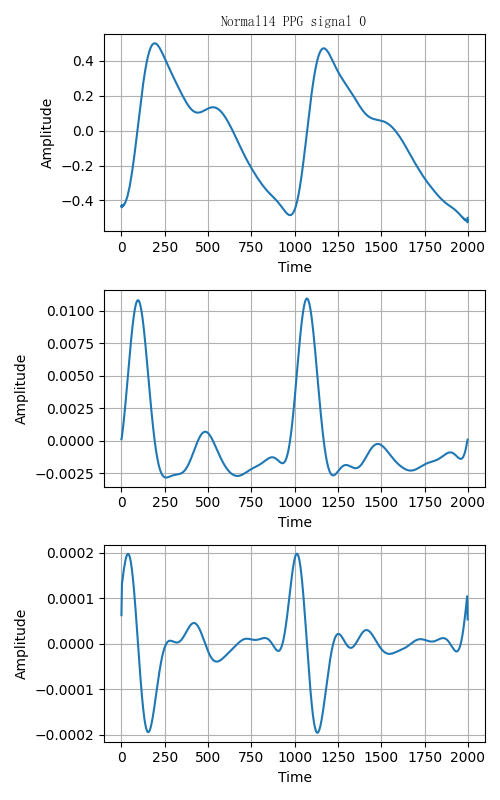

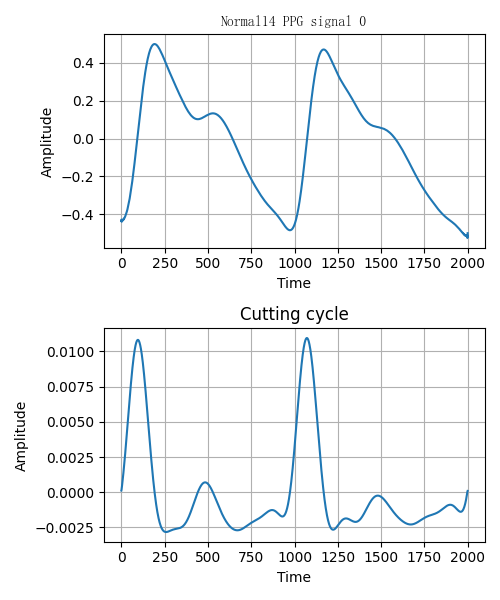

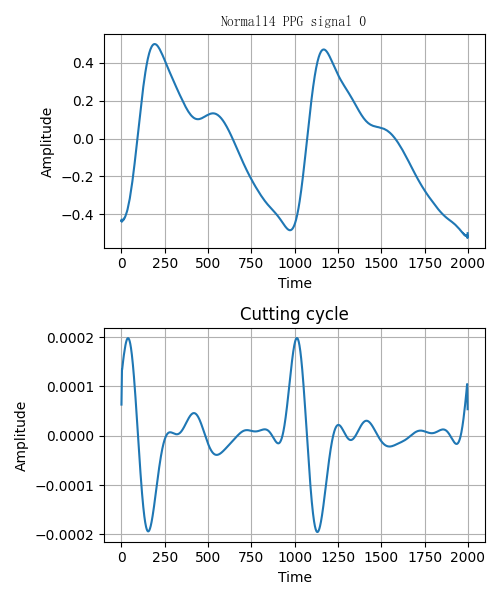

Processing: 100%|██████████| 63/63 [00:03<00:00, 15.87it/s]


In [9]:
if __name__ == '__main__':
    analyze()
    #main()